
# Dogecoin (DOGE-USD) — Advanced Prediction Notebook

**What's inside**  
- Rich feature engineering (regime features, breakouts, candle stats)  
- Multi-horizon targets: next-day (t+1), 3-day (t+3), 5-day (t+5) **log returns & direction**  
- Optional **exogenous signals**: BTC, ETH, DXY, funding rates, on-chain (merge by date)  
- **Walk-forward CV** with **threshold tuning** to optimize strategy performance  
- Tree ensembles with **RandomizedSearchCV** (+ optional XGBoost/LightGBM if available)  
- Optional **sequence models** (LSTM/TCN) with strict time CV and leakage guards (PyTorch if available)  

> Place your DOGE file at `./../Dataset/DOGE-USD.csv`. Exogenous files are optional (see the corresponding section).


## 0) Setup & Utilities

In [2]:

import os, math, joblib, warnings, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score, roc_auc_score, roc_curve
)

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,7)
pd.set_option("display.max_columns", 160)

try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

try:
    import torch
    from torch import nn
    HAS_TORCH = True
except Exception:
    HAS_TORCH = False

random.seed(42); np.random.seed(42)


## 1) Load DOGE-USD data

In [3]:

csv_path = "./../Dataset/DOGE-USD.csv"
df = pd.read_csv(csv_path)

df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
date_col_candidates = [c for c in df.columns if c in ["date","timestamp","time"]]
if not date_col_candidates:
    raise ValueError("Expected a 'Date' column in DOGE-USD.csv")
date_col = date_col_candidates[0]
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(date_col).reset_index(drop=True)

ren = {}
for std, cands in {
    "open": ["open"], "high":["high"], "low":["low"],
    "close":["close","adj_close","adjclose"], "volume":["volume"]
}.items():
    for c in cands:
        if c in df.columns: ren[c]=std; break
df = df.rename(columns=ren)

req = ["open","high","low","close","volume"]
missing = [c for c in req if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")
df.head()


,date,open,high,low,close,adj_close,volume
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550.0
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520.0
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080.0
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960.0
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270.0



## 2) (Optional) Add exogenous signals
Provide CSVs with a `Date` (or `date/timestamp`) column and a price/metric column.  
Paths below are examples—update them if you have the files.


In [4]:

exogenous_specs = [
    # {"path": "./../Dataset/BTC-USD.csv", "price_col": "Close", "prefix": "btc"},
    # {"path": "./../Dataset/ETH-USD.csv", "price_col": "Close", "prefix": "eth"},
    # {"path": "./../Dataset/DXY.csv",     "price_col": "Close", "prefix": "dxy"},
]

exo_frames = []
for spec in exogenous_specs:
    try:
        exo = pd.read_csv(spec["path"])
        exo.columns = [c.strip().replace(" ","_").lower() for c in exo.columns]
        dc = "date" if "date" in exo.columns else ("timestamp" if "timestamp" in exo.columns else None)
        if dc is None: 
            raise ValueError("No date/timestamp column found in exogenous file.")
        exo[dc] = pd.to_datetime(exo[dc])
        exo = exo.rename(columns={spec["price_col"].lower():"close"})
        exo = exo[[dc, "close"]].sort_values(dc).reset_index(drop=True)
        exo = exo.rename(columns={"close": f"{spec['prefix']}_close", dc: "date"})
        exo[f"{spec['prefix']}_ret_1d"] = exo[f"{spec['prefix']}_close"].pct_change()
        exo[f"{spec['prefix']}_logret_1d"] = np.log(exo[f"{spec['prefix']}_close"]).diff()
        exo_frames.append(exo)
    except Exception as e:
        print(f"Skipping exogenous {spec.get('path','?')} due to: {e}")

if exo_frames:
    from functools import reduce
    merged_exo = reduce(lambda l,r: pd.merge(l,r, on="date", how="left"), exo_frames)
    df = pd.merge(df, merged_exo, left_on=date_col, right_on="date", how="left")
    df.drop(columns=["date"], inplace=True)
df.head()


,date,open,high,low,close,adj_close,volume
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550.0
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520.0
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080.0
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960.0
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270.0


## 3) Feature Engineering (technical + regime + structure)

In [5]:

feat = df[[date_col, "open","high","low","close","volume"]].copy()

feat["log_close"] = np.log(feat["close"].replace(0, np.nan))
feat["log_ret_1d"] = feat["log_close"].diff()

for lag in [1,2,3,5,10]:
    feat[f"log_ret_lag_{lag}"] = feat["log_ret_1d"].shift(lag)

for w in [5,10,21,50,100]:
    feat[f"sma_{w}"] = feat["close"].rolling(w).mean()
for w in [5,21]:
    feat[f"rstd_{w}"] = feat["close"].rolling(w).std()

mid = feat["close"].rolling(20).mean()
std = feat["close"].rolling(20).std()
upper = mid + 2*std; lower = mid - 2*std
feat["bb_width"] = (upper - lower) / (mid + 1e-12)

feat["ema_12"] = feat["close"].ewm(span=12, adjust=False).mean()
feat["ema_26"] = feat["close"].ewm(span=26, adjust=False).mean()
feat["macd"] = feat["ema_12"] - feat["ema_26"]
feat["macd_signal"] = feat["macd"].ewm(span=9, adjust=False).mean()
feat["macd_hist"] = feat["macd"] - feat["macd_signal"]

delta = feat["close"].diff()
gain = np.where(delta>0, delta, 0.0); loss = np.where(delta<0, -delta, 0.0)
roll_up = pd.Series(gain, index=feat.index).rolling(14).mean()
roll_dn = pd.Series(loss, index=feat.index).rolling(14).mean()
rs = roll_up/(roll_dn + 1e-12)
feat["rsi_14"] = 100 - (100/(1+rs))

for w in [10,20]:
    rv = feat["log_ret_1d"].rolling(w).std() * np.sqrt(365)
    feat[f"hv_{w}"] = rv

n = 14
up_move = feat["high"].diff()
down_move = -feat["low"].diff()
plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
tr1 = feat["high"] - feat["low"]
tr2 = (feat["high"] - feat["close"].shift(1)).abs()
tr3 = (feat["low"] - feat["close"].shift(1)).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
atr = tr.rolling(n).mean()
plus_di = 100 * (pd.Series(plus_dm).rolling(n).mean() / (atr + 1e-12))
minus_di = 100 * (pd.Series(minus_dm).rolling(n).mean() / (atr + 1e-12))
dx = ( (plus_di - minus_di).abs() / (plus_di + minus_di + 1e-12) ) * 100
feat["adx_14"] = dx.rolling(n).mean()

for w in [20,55]:
    hh = feat["high"].rolling(w).max()
    ll = feat["low"].rolling(w).min()
    feat[f"dist_from_hh_{w}"] = (feat["close"] - hh) / (hh + 1e-12)
    feat[f"dist_from_ll_{w}"] = (feat["close"] - ll) / (ll + 1e-12)
    feat[f"breakout_up_{w}"] = (feat["close"] > hh.shift(1)).astype(int)
    feat[f"breakout_dn_{w}"] = (feat["close"] < ll.shift(1)).astype(int)

body = (feat["close"] - feat["open"]).abs()
range_ = (feat["high"] - feat["low"]).replace(0, np.nan)
upper_wick = (feat["high"] - feat[["close","open"]].max(axis=1))
lower_wick = (feat[["close","open"]].min(axis=1) - feat["low"])
feat["candle_body_pct"] = (body / range_).fillna(0)
feat["upper_wick_pct"] = (upper_wick / range_).fillna(0)
feat["lower_wick_pct"] = (lower_wick / range_).fillna(0)
feat["marubozu_like"] = ((feat["upper_wick_pct"]<0.05) & (feat["lower_wick_pct"]<0.05)).astype(int)

feat["dow"] = pd.to_datetime(feat[date_col]).dt.dayofweek
feat = pd.concat([feat, pd.get_dummies(feat["dow"], prefix="dow", drop_first=True)], axis=1)

for c in df.columns:
    if c.endswith("_logret_1d") and c not in feat.columns:
        feat[c] = df[c]

feat.head()


,date,open,high,low,close,volume,log_close,log_ret_1d,log_ret_lag_1,log_ret_lag_2,log_ret_lag_3,log_ret_lag_5,log_ret_lag_10,sma_5,sma_10,sma_21,sma_50,sma_100,rstd_5,rstd_21,bb_width,ema_12,ema_26,macd,macd_signal,macd_hist,rsi_14,hv_10,hv_20,adx_14,dist_from_hh_20,dist_from_ll_20,breakout_up_20,breakout_dn_20,dist_from_hh_55,dist_from_ll_55,breakout_up_55,breakout_dn_55,candle_body_pct,upper_wick_pct,lower_wick_pct,marubozu_like,dow,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,2017-11-09,0.001207,0.001415,0.001181,0.001415,6259550.0,-6.560626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001415,0.001415,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,0.888889,0.000000,0.111111,0,3,False,False,True,False,False,False
1,2017-11-10,0.001421,0.001431,0.001125,0.001163,4246520.0,-6.756752,-0.196127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001376,0.001396,-0.000020,-0.000004,-0.000016,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,0.843137,0.032680,0.124183,0,4,False,False,False,True,False,False
2,2017-11-11,0.001146,0.001257,0.001141,0.001201,2231080.0,-6.724601,0.032152,-0.196127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001349,0.001382,-0.000033,-0.000010,-0.000023,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,0.474138,0.482759,0.043103,0,5,False,False,False,False,True,False
3,2017-11-12,0.001189,0.001210,0.001002,0.001038,3288960.0,-6.870459,-0.145859,0.032152,-0.196127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001301,0.001356,-0.000055,-0.000019,-0.000036,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,0.725962,0.100962,0.173077,0,6,False,False,False,False,False,True
4,2017-11-13,0.001046,0.001212,0.001019,0.001211,2481270.0,-6.716309,0.154151,-0.145859,0.032152,-0.196127,NaN,NaN,0.001206,NaN,NaN,NaN,NaN,0.000136,NaN,NaN,0.001287,0.001346,-0.000058,-0.000027,-0.000031,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,0.854922,0.005181,0.139896,0,0,False,False,False,False,False,False


## 4) Targets (t+1, t+3, t+5)

In [6]:

def horizon_logret(series, h):
    return np.log(series).shift(-h) - np.log(series)

for h in [1,3,5]:
    feat[f"y_logret_t{h}"] = horizon_logret(feat["close"], h)
    feat[f"y_up_t{h}"] = (feat[f"y_logret_t{h}"] > 0).astype(int)

feat = feat.dropna().reset_index(drop=True)
feat.head()


,date,open,high,low,close,volume,log_close,log_ret_1d,log_ret_lag_1,log_ret_lag_2,log_ret_lag_3,log_ret_lag_5,log_ret_lag_10,sma_5,sma_10,sma_21,sma_50,sma_100,rstd_5,rstd_21,bb_width,ema_12,ema_26,macd,macd_signal,macd_hist,rsi_14,hv_10,hv_20,adx_14,dist_from_hh_20,dist_from_ll_20,breakout_up_20,breakout_dn_20,dist_from_hh_55,dist_from_ll_55,breakout_up_55,breakout_dn_55,candle_body_pct,upper_wick_pct,lower_wick_pct,marubozu_like,dow,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,y_logret_t1,y_up_t1,y_logret_t3,y_up_t3,y_logret_t5,y_up_t5
0,2018-02-16,0.007295,0.007485,0.006529,0.007034,26553900.0,-4.957000,-0.043537,0.087717,0.177046,0.029885,-0.006637,0.210554,0.006444,0.005603,0.005563,0.008123,0.005787,0.000843,0.001187,0.833695,0.005944,0.006232,-0.000288,-0.000713,0.000425,69.203062,1.289229,2.293398,49.720703,-0.114997,1.316864,0,0,-0.625313,1.316864,0,0,0.273013,0.198745,0.528243,0,4,False,False,False,True,False,False,0.002130,1,-0.049096,0,-0.066569,0
1,2018-02-17,0.007064,0.007322,0.006853,0.007049,18333100.0,-4.954870,0.002130,-0.043537,0.087717,0.177046,0.099045,-0.014784,0.006760,0.005878,0.005548,0.008076,0.005843,0.000664,0.001164,0.811209,0.006114,0.006292,-0.000178,-0.000606,0.000428,65.737185,1.259636,2.292549,48.287945,-0.113110,1.321805,0,0,-0.624514,1.321805,0,0,0.031983,0.550107,0.417910,0,5,False,False,False,False,True,False,-0.092845,0,0.006364,1,-0.118865,0
2,2018-02-18,0.007114,0.007144,0.006330,0.006424,15291500.0,-5.047714,-0.092845,0.002130,-0.043537,0.087717,0.029885,0.060720,0.006917,0.006064,0.005498,0.008047,0.005896,0.000351,0.001098,0.790949,0.006162,0.006302,-0.000140,-0.000513,0.000373,67.310651,1.519091,2.307952,46.307494,-0.191746,1.115942,0,0,-0.657806,1.115942,0,0,0.847666,0.036855,0.115479,0,6,False,False,False,False,False,True,0.041619,1,0.024146,1,0.034275,1
3,2018-02-19,0.006410,0.006938,0.006341,0.006697,13019200.0,-5.006096,0.041619,-0.092845,0.002130,-0.043537,0.177046,0.090800,0.006910,0.006234,0.005485,0.008001,0.005951,0.000356,0.001082,0.808000,0.006244,0.006331,-0.000087,-0.000428,0.000340,80.098934,1.473057,2.224668,45.774567,-0.157398,1.205863,0,0,-0.643264,1.205863,0,0,0.480737,0.403685,0.115578,0,0,False,False,False,False,False,False,0.057590,1,-0.067639,0,-0.057308,0
4,2018-02-20,0.006679,0.008288,0.006399,0.007094,107911000.0,-4.948506,0.057590,0.041619,-0.092845,0.002130,0.087717,-0.002202,0.006860,0.006444,0.005536,0.007965,0.006011,0.000290,0.001132,0.839139,0.006375,0.006388,-0.000013,-0.000345,0.000332,78.321243,1.465601,2.235424,46.523862,-0.144064,1.336627,0,0,-0.622117,1.336627,0,0,0.219693,0.632080,0.148227,0,1,True,False,False,False,False,False,-0.075063,0,-0.064933,0,-0.144099,0


## 5) Train/Test split

In [7]:

n = len(feat)
split_idx = int(n*0.8)
train_df = feat.iloc[:split_idx].copy()
test_df  = feat.iloc[split_idx:].copy()

exclude = { "y_logret_t1","y_up_t1","y_logret_t3","y_up_t3","y_logret_t5","y_up_t5", "dow",
            "date", "timestamp", "time" }
exclude.add(date_col)

X_cols = [c for c in feat.columns if c not in exclude]
X_train = train_df[X_cols].copy()
X_test  = test_df[X_cols].copy()

targets_reg = {h: train_df[f"y_logret_t{h}"] for h in [1,3,5]}
targets_cls = {h: train_df[f"y_up_t{h}"] for h in [1,3,5]}

y_test_reg = {h: test_df[f"y_logret_t{h}"] for h in [1,3,5]}
y_test_cls = {h: test_df[f"y_up_t{h}"] for h in [1,3,5]}

len(train_df), len(test_df), len(X_cols)


(1324, 332, 47)

## 6) Preprocess pipeline

In [8]:

numeric_features = X_cols
pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), numeric_features)
], remainder="drop")


## 7) Walk-forward CV with threshold tuning

In [9]:

def walk_forward_threshold_search(model, X, y_up, y_logret, n_splits=5, thresholds=np.linspace(0.5, 0.7, 9)):
    """
    For each fold, fit on train, predict proba on val, then choose threshold maximizing
    cumulative growth of strategy based on next-horizon *log returns*.
    Returns average best threshold and fold-wise results.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_thresholds = []
    fold_results = []
    for fold, (tr, va) in enumerate(tscv.split(X)):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva_up = y_up.iloc[tr], y_up.iloc[va]
        yva_lr = y_logret.iloc[va]  # for growth computation
        
        mdl = Pipeline([("pre", pre), ("clf", model)])
        mdl.fit(Xtr, ytr)
        proba = mdl.predict_proba(Xva)[:,1]
        
        def growth(th):
            sig = (proba >= th).astype(int)
            strat = np.exp(np.cumsum(sig * yva_lr.values))[-1]  # end growth
            return strat
        
        th_best = thresholds[0]; best = -np.inf
        for th in thresholds:
            g = growth(th)
            if g > best:
                best, th_best = g, th
        best_thresholds.append(th_best)
        fold_results.append({"fold": fold+1, "best_threshold": th_best, "best_growth": best})
    return float(np.mean(best_thresholds)), pd.DataFrame(fold_results)

base_clf = LogisticRegression(max_iter=2000, class_weight="balanced")

best_th_t1, folds_t1 = walk_forward_threshold_search(base_clf, X_train, targets_cls[1], targets_reg[1])
best_th_t3, folds_t3 = walk_forward_threshold_search(base_clf, X_train, targets_cls[3], targets_reg[3])
best_th_t5, folds_t5 = walk_forward_threshold_search(base_clf, X_train, targets_cls[5], targets_reg[5])

print("Best thresholds (avg over folds):", {"t+1": best_th_t1, "t+3": best_th_t3, "t+5": best_th_t5})
folds_t1, folds_t3, folds_t5


Best thresholds (avg over folds): {'t+1': 0.58, 't+3': 0.58, 't+5': 0.5599999999999999}


(   fold  best_threshold  best_growth
 0     1           0.700     0.662445
 1     2           0.575     1.191574
 2     3           0.575     2.399248
 3     4           0.550     4.662731
 4     5           0.500     2.154556,
    fold  best_threshold  best_growth
 0     1           0.675     0.757347
 1     2           0.500     1.147916
 2     3           0.625     7.819196
 3     4           0.500     8.186326
 4     5           0.600     1.816192,
    fold  best_threshold  best_growth
 0     1           0.700     0.422247
 1     2           0.525     1.688899
 2     3           0.575     6.938625
 3     4           0.500     6.618554
 4     5           0.500     0.774224)

## 8) Tree ensembles with RandomizedSearchCV

In [10]:

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
param_dist = {
    "clf__n_estimators": [200, 300, 400],
    "clf__max_depth": [None, 5, 10, 15],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}
pipe_rf = Pipeline([("pre", pre), ("clf", rf)])
tscv = TimeSeriesSplit(n_splits=5)

search_rf = RandomizedSearchCV(
    pipe_rf, param_distributions=param_dist, n_iter=10, cv=tscv,
    scoring="roc_auc", random_state=42, n_jobs=-1
)
search_rf.fit(X_train, targets_cls[1])
print("RF best params:", search_rf.best_params_)
print("RF best AUC:", search_rf.best_score_)

best_booster = None
if 'xgb' in globals() and HAS_XGB:
    xgb_clf = xgb.XGBClassifier(
        objective="binary:logistic", eval_metric="auc", tree_method="hist",
        n_estimators=400, random_state=42
    )
    pipe_xgb = Pipeline([("pre", pre), ("clf", xgb_clf)])
    search_xgb = RandomizedSearchCV(
        pipe_xgb,
        param_distributions={
            "clf__max_depth":[3,4,5,6],
            "clf__learning_rate":[0.03,0.05,0.1],
            "clf__subsample":[0.7,0.9,1.0],
            "clf__colsample_bytree":[0.7,0.9,1.0]
        },
        n_iter=10, cv=tscv, scoring="roc_auc", random_state=42, n_jobs=-1
    )
    search_xgb.fit(X_train, targets_cls[1])
    print("XGB best AUC:", search_xgb.best_score_)
    best_booster = search_xgb.best_estimator_

elif 'lgb' in globals() and HAS_LGBM:
    lgbm = lgb.LGBMClassifier(n_estimators=500, random_state=42)
    pipe_lgb = Pipeline([("pre", pre), ("clf", lgbm)])
    search_lgb = RandomizedSearchCV(
        pipe_lgb,
        param_distributions={
            "clf__num_leaves":[31,63,127],
            "clf__learning_rate":[0.03,0.05,0.1],
            "clf__min_child_samples":[10,20,40],
            "clf__subsample":[0.7,0.9,1.0]
        },
        n_iter=10, cv=tscv, scoring="roc_auc", random_state=42, n_jobs=-1
    )
    search_lgb.fit(X_train, targets_cls[1])
    print("LGBM best AUC:", search_lgb.best_score_)
    best_booster = search_lgb.best_estimator_

best_model = best_booster if best_booster is not None else search_rf.best_estimator_


RF best params: {'clf__n_estimators': 300, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_depth': 10}
RF best AUC: 0.5197030244459828
XGB best AUC: 0.5226807454311473


## 9) Final models per horizon + evaluation on test

In [11]:

from sklearn.linear_model import RidgeCV

ridge = Pipeline([("pre", pre), ("reg", RidgeCV(alphas=np.logspace(-4,4,21)))])
ridge.fit(X_train, targets_reg[1])
ridge_pred_t1 = ridge.predict(X_test)
ridge_mae = mean_absolute_error(y_test_reg[1], ridge_pred_t1)
ridge_r2  = r2_score(y_test_reg[1], ridge_pred_t1)

def eval_horizon(h, tuned_th):
    mdl = best_model
    mdl.fit(X_train, targets_cls[h])
    proba = mdl.predict_proba(X_test)[:,1]
    pred = (proba >= tuned_th).astype(int)
    acc = accuracy_score(y_test_cls[h], pred)
    auc = roc_auc_score(y_test_cls[h], proba)
    strat = np.exp(np.cumsum((pred * y_test_reg[h].values)))[-1]
    bh = np.exp(np.cumsum(y_test_reg[h].values))[-1]
    return {"horizon": h, "threshold": tuned_th, "acc": acc, "auc": auc, "strategy_growth": strat, "buy_hold_growth": bh}

res_t1 = eval_horizon(1, best_th_t1)
res_t3 = eval_horizon(3, best_th_t3)
res_t5 = eval_horizon(5, best_th_t5)

summary = pd.DataFrame([
    {"Metric":"Ridge MAE (t+1 logret)","Value":ridge_mae},
    {"Metric":"Ridge R2 (t+1 logret)","Value":ridge_r2},
    {"Metric":f"ACC t+1 (th={res_t1['threshold']:.2f})","Value":res_t1["acc"]},
    {"Metric":f"AUC t+1","Value":res_t1["auc"]},
    {"Metric":f"Strategy Growth t+1","Value":res_t1["strategy_growth"]},
    {"Metric":f"Buy&Hold Growth t+1","Value":res_t1["buy_hold_growth"]},
    {"Metric":f"ACC t+3 (th={res_t3['threshold']:.2f})","Value":res_t3["acc"]},
    {"Metric":f"AUC t+3","Value":res_t3["auc"]},
    {"Metric":f"Strategy Growth t+3","Value":res_t3["strategy_growth"]},
    {"Metric":f"Buy&Hold Growth t+3","Value":res_t3["buy_hold_growth"]},
    {"Metric":f"ACC t+5 (th={res_t5['threshold']:.2f})","Value":res_t5["acc"]},
    {"Metric":f"AUC t+5","Value":res_t5["auc"]},
    {"Metric":f"Strategy Growth t+5","Value":res_t5["strategy_growth"]},
    {"Metric":f"Buy&Hold Growth t+5","Value":res_t5["buy_hold_growth"]},
])
summary


,Metric,Value
0,Ridge MAE (t+1 logret),0.035611
1,Ridge R2 (t+1 logret),-0.030154
2,ACC t+1 (th=0.58),0.503012
3,AUC t+1,0.505680
4,Strategy Growth t+1,0.306485
5,Buy&Hold Growth t+1,0.290620
6,ACC t+3 (th=0.58),0.539157
7,AUC t+3,0.554896
8,Strategy Growth t+3,0.621824
9,Buy&Hold Growth t+3,0.020635


### ROC curves on test (each horizon)

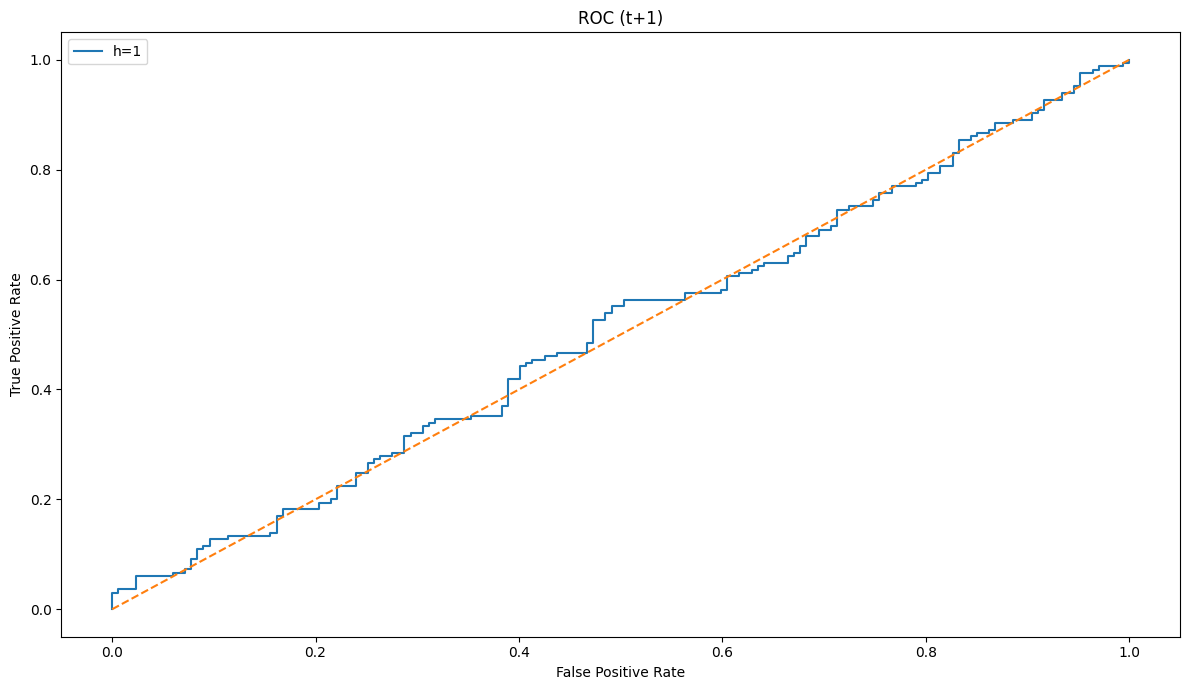

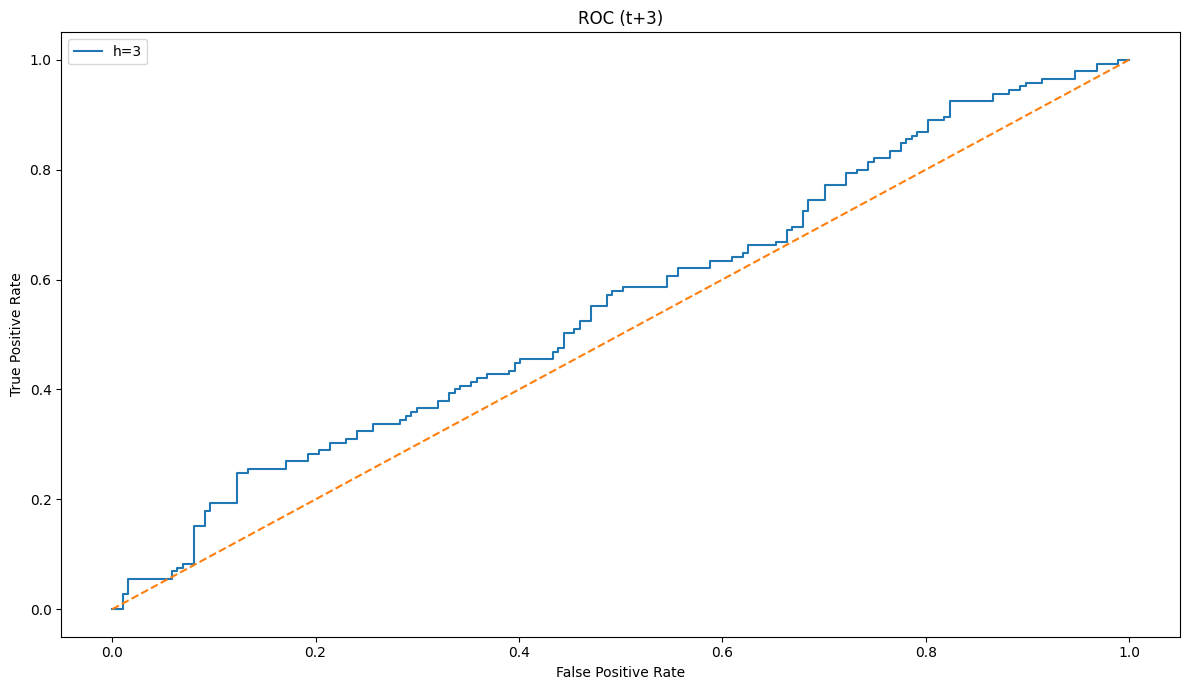

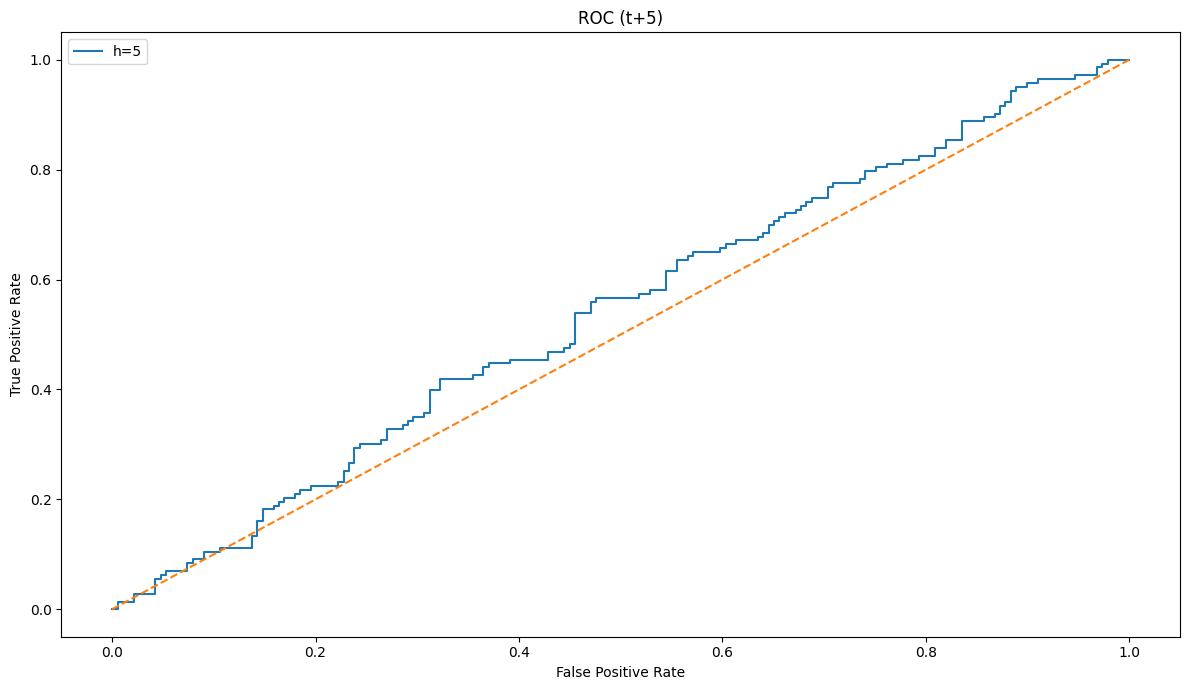

In [12]:

for h, tuned_th in [(1, best_th_t1),(3, best_th_t3),(5, best_th_t5)]:
    mdl = best_model
    mdl.fit(X_train, targets_cls[h])
    proba = mdl.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test_cls[h], proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"h={h}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(f"ROC (t+{h})")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 10) Save artifacts

In [14]:

joblib.dump(best_model, "./../models/adv_best_classifier.pkl")
joblib.dump(ridge, "./../models/adv_ridge_regressor.pkl")
with open("./../Dataset/adv_feature_columns.txt","w") as f:
    for c in X_cols: f.write(c+"\n")

print("Saved:")
print("- ./../models/adv_best_classifier.pkl")
print("- ./../models/adv_ridge_regressor.pkl")
print("- ./../models/adv_feature_columns.txt")


Saved:
- ./../models/adv_best_classifier.pkl
- ./../models/adv_ridge_regressor.pkl
- ./../models/adv_feature_columns.txt


Exception ignored in: <function ResourceTracker.__del__ at 0x1073cbf60>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1037fff60>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.frame


## Notes & Guidance
- **Leakage:** All rolling computations are purely backward-looking; ensure any future merges respect time order.
- **Thresholds:** We tune thresholds using fold validation growth. You may target Sharpe-like metrics instead.
- **Exogenous:** Add BTC/ETH/DXY CSVs and set `exogenous_specs` to enrich features.
- **Hyperparameters:** Increase `n_iter` and search spaces if you have more compute.
- **Sequence models:** For proper experiments, increase epochs, add validation splits, early stopping, and walk-forward evaluation.
